#Import libraries and preprocess the data

In [0]:
'''Import of libraries'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras as kr
from sklearn import metrics
import itertools


In [0]:
'''Path to the data txt files on disk.'''

from google.colab import drive
drive.mount('/content/gdrive')

data_path = '/content/gdrive/My Drive/Colab Notebooks/namesbystate/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
'''Import data to programm'''

name_of_txt = ['MS.TXT','RI.TXT','WV.TXT','NE.TXT','MA.TXT','NV.TXT','MI.TXT','CO.TXT','HI.TXT','SC.TXT','AL.TXT','MO.TXT','AR.TXT','OR.TXT','IN.TXT',
               'IL.TXT','OH.TXT','IA.TXT','KY.TXT','KS.TXT','PA.TXT','FL.TXT','WA.TXT','LA.TXT','NY.TXT','WI.TXT','AZ.TXT','NJ.TXT','CA.TXT','ID.TXT',
               'AK.TXT','VA.TXT','TX.TXT','UT.TXT','NM.TXT','ND.TXT','MT.TXT','DE.TXT','GA.TXT','MD.TXT','TN.TXT','OK.TXT','NC.TXT','CT.TXT','SD.TXT',
               'VT.TXT','NH.TXT','ME.TXT','WY.TXT','DC.TXT','MN.TXT']
frames = []

for txt in name_of_txt:
  ds = pd.read_csv(data_path+txt, delimiter=",",header = None)
  frames.append(ds)
  #print(txt + " done")
#print("All files imported succesfully.")


dataset = pd.concat(frames)
dataset = dataset.drop(columns=[0,2,4])
dataset.columns = ['Sex', 'Name']
dataset = dataset.drop_duplicates(keep='first')
dataset['Name'] = dataset['Name'].str.lower()



dataset = dataset.sample(frac=1, axis=0).reset_index(drop=True) #shuffle
dataset = dataset.drop_duplicates(subset = 'Name',keep = False)
print(dataset)
print(dataset.shape)


      Sex       Name
0       F     mariko
1       M     torben
4       F     emelia
5       M      talan
6       M    lynwood
8       M     hoskie
10      M       hung
11      F     allyna
12      M       akul
13      F    nyiesha
14      F    lilyona
16      F     vernee
17      M     donzel
18      F    lyndsie
21      F      vaani
22      F    yexalen
23      M    ismaeel
24      F    jacklin
25      F      nahla
27      F  annemarie
28      M     joshus
29      M  siddhanth
30      F    shenise
32      F    kamaria
33      M    carthel
34      F   claramae
35      F    xiclaly
37      F     janyll
38      F     hodaya
39      F     amyrie
...    ..        ...
34288   F    neleigh
34290   F    ashante
34293   F     hailea
34294   F     yasmin
34295   F    shanice
34296   F     lowana
34297   M      jabez
34299   F       zela
34301   F      kirti
34302   M    nickson
34303   M    jacobey
34304   M    matteus
34305   M    mustafe
34306   F     lilyth
34307   M     zachry
34308   M    

In [0]:
'''Set names from alphabetical encoding to nummerical, e.g. a->1, h->8'''

def encode_in_number(word):
  return_vector = []
  for letter in word:
    return_vector.append(ord(letter)-97)
  return return_vector

def str_to_int(character):
  return_value = 0
  if(character=="M"):
    return_value = 1
  return return_value

dataset['encode'] = dataset['Name'].map(encode_in_number)
dataset['sex_labeled'] = dataset['Sex'].map(str_to_int)
print(dataset)


      Sex       Name                           encode  sex_labeled
0       F     mariko           [12, 0, 17, 8, 10, 14]            0
1       M     torben           [19, 14, 17, 1, 4, 13]            1
4       F     emelia             [4, 12, 4, 11, 8, 0]            0
5       M      talan               [19, 0, 11, 0, 13]            1
6       M    lynwood      [11, 24, 13, 22, 14, 14, 3]            1
8       M     hoskie            [7, 14, 18, 10, 8, 4]            1
10      M       hung                   [7, 20, 13, 6]            1
11      F     allyna           [0, 11, 11, 24, 13, 0]            0
12      M       akul                  [0, 10, 20, 11]            1
13      F    nyiesha         [13, 24, 8, 4, 18, 7, 0]            0
14      F    lilyona       [11, 8, 11, 24, 14, 13, 0]            0
16      F     vernee            [21, 4, 17, 13, 4, 4]            0
17      M     donzel           [3, 14, 13, 25, 4, 11]            1
18      F    lyndsie        [11, 24, 13, 3, 18, 8, 4]         

In [0]:
'''Split to train and test'''

msk = np.random.rand(len(dataset)) < 0.8
train = dataset[msk]
test = dataset[~msk]
train_labels = train['sex_labeled']
train_data = train['encode']
test_labels = test['sex_labeled']
test_data = test['encode']


#Define models and train

In [0]:
'''Models definitions'''

max_len = 20  # maximum length of sequence

sequences_matrix = kr.preprocessing.sequence.pad_sequences(train_data,maxlen=max_len)

def my_deep_LSTM():
    inputs = kr.layers.Input(name='inputs',shape=[max_len])  # core layer of inputs
    layer1 = kr.layers.Embedding(input_dim=100, output_dim=50, input_length=max_len)(inputs)  # embedding layer, that represents 
                                                             # letters of words in dense vector representation. Layer will be max_len 
                                                             # vectors of 50 dim each
    layer2 = kr.layers.LSTM(64,return_sequences=True)(layer1)  # LSTM layerwith 64 units (cells)
    layer3 = kr.layers.Activation('relu')(layer2)  # activation function (relu) applicated to the layer4
 
    layer4 = kr.layers.LSTM(64,return_sequences=True)(layer3)
    layer5 = kr.layers.Activation('relu')(layer4)
 
    layer6 = kr.layers.LSTM(64)(layer5)
    layer7 = kr.layers.Activation('relu')(layer6)    
 
    layer8 = kr.layers.Dense(units=2,name='out_layer')(layer7) 
    layer9 = kr.layers.Activation('softmax')(layer8)
    model = kr.models.Model(inputs=inputs,outputs=layer9)  # creates a model from layers above
    return model

def my_LSTM():
    inputs = kr.layers.Input(name='inputs',shape=[max_len])  # core layer of inputs
    layer1 = kr.layers.Embedding(input_dim=100, output_dim=50, input_length=max_len)(inputs)  # embedding layer, that represents 
                                                             # letters of words indense vector representation. Layer will be max_len 
                                                             # vectors of 50 dim each
    layer2 = kr.layers.LSTM(64)(layer1)  # LSTM layerwith 64 units (cells)
    layer3 = kr.layers.Dense(units=2,name='out_layer')(layer2)  # this is a classic core layer of perceprtons it takes as input matrix shaped
                                                      # as "layer5" and returns shape (*, 256). Layer without activation
    layer4 = kr.layers.Activation('softmax')(layer3)  # activation function (relu) applicated to the layer4
    model = kr.models.Model(inputs=inputs,outputs=layer4)  # creates a model from layers above
    return model

def my_GRU():
    inputs = kr.layers.Input(name='inputs',shape=[max_len])  # core layer of inputs
    layer1 = kr.layers.Embedding(input_dim=100, output_dim=50, input_length=max_len)(inputs)  # embedding layer, that represents 
                                                             # letters of words indense vector representation. Layer will be max_len 
                                                             # vectors of 50 dim each
    layer2 = kr.layers.GRU(64)(layer1)  # LSTM layer with 64 units (cells)
    layer3 = kr.layers.Dense(units=2,name='out_layer')(layer2)  # this is a classic core layer of perceprtons it takes as input matrix shaped
                                                      # as "layer5" and returns shape (*, 256). Layer without activation
    layer4 = kr.layers.Activation('softmax')(layer3)  # activation function (relu) applicated to the layer4
    model = kr.models.Model(inputs=inputs,outputs=layer4)  # creates a model from layers above
    return model

def my_simple_RNN():
    inputs = kr.layers.Input(name='inputs',shape=[max_len])  # core layer of inputs
    layer1 = kr.layers.Embedding(input_dim=100, output_dim=50, input_length=max_len)(inputs)  # embedding layer, that represents 
                                                             # letters of words indense vector representation. Layer will be max_len 
                                                             # vectors of 50 dim each
    layer2 = kr.layers.SimpleRNN(64)(layer1)  # LSTM layer with 64 units (cells)
    layer3 = kr.layers.Dense(units=2,name='out_layer')(layer2)  # this is a classic core layer of perceprtons it takes as input matrix shaped
                                                      # as "layer5" and returns shape (*, 256). Layer without activation
    layer4 = kr.layers.Activation('softmax')(layer3)  # activation function (relu) applicated to the layer4
    model = kr.models.Model(inputs=inputs,outputs=layer4)  # creates a model from layers above
    return model  
  

In [0]:
'''Setting up training'''

model = my_LSTM()
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=kr.optimizers.RMSprop(),metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 20)                0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 20, 50)            5000      
_________________________________________________________________
lstm_30 (LSTM)               (None, 64)                29440     
_________________________________________________________________
out_layer (Dense)            (None, 2)                 130       
_________________________________________________________________
activation_42 (Activation)   (None, 2)                 0         
Total params: 34,570
Trainable params: 34,570
Non-trainable params: 0
_________________________________________________________________


In [0]:
'''Train model'''

batch_size = 100
epochs = 40
validation_split = 0.225

history = model.fit(sequences_matrix, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split,
          callbacks=[kr.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])
              #kr.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001)])

print(history.history.keys())


Train on 17542 samples, validate on 5094 samples
Epoch 1/40
17542/17542 [==============================] - 16s 898us/step - loss: 0.4926 - acc: 0.7598 - val_loss: 0.4031 - val_acc: 0.8274
Epoch 2/40
17542/17542 [==============================] - 12s 657us/step - loss: 0.3973 - acc: 0.8270 - val_loss: 0.4017 - val_acc: 0.8223
Epoch 3/40
17542/17542 [==============================] - 12s 658us/step - loss: 0.3894 - acc: 0.8290 - val_loss: 0.3913 - val_acc: 0.8327
Epoch 4/40
17542/17542 [==============================] - 12s 660us/step - loss: 0.3835 - acc: 0.8317 - val_loss: 0.3877 - val_acc: 0.8333
Epoch 5/40
17542/17542 [==============================] - 11s 654us/step - loss: 0.3788 - acc: 0.8346 - val_loss: 0.3845 - val_acc: 0.8359
Epoch 6/40
17542/17542 [==============================] - 12s 657us/step - loss: 0.3744 - acc: 0.8373 - val_loss: 0.3785 - val_acc: 0.8378
Epoch 7/40
17542/17542 [==============================] - 12s 658us/step - loss: 0.3676 - acc: 0.8415 - val_loss: 0.3

#Test classifier and visualise training 

In [0]:
'''Test on testing batch'''

test_sequences_matrix = kr.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,test_labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

predictions = model.predict(test_sequences_matrix)
matrix = metrics.confusion_matrix(list(test_labels), predictions.argmax(axis=1))
print("matrix", type(matrix), matrix.shape)
print(matrix)
print("predictions", type(predictions), predictions.shape)


5667/5667 [==============================] - 4s 725us/step
Test set
  Loss: 0.298
  Accuracy: 0.893
matrix <class 'numpy.ndarray'> (2, 2)
[[3241  288]
 [ 317 1821]]
predictions <class 'numpy.ndarray'> (5667, 2)


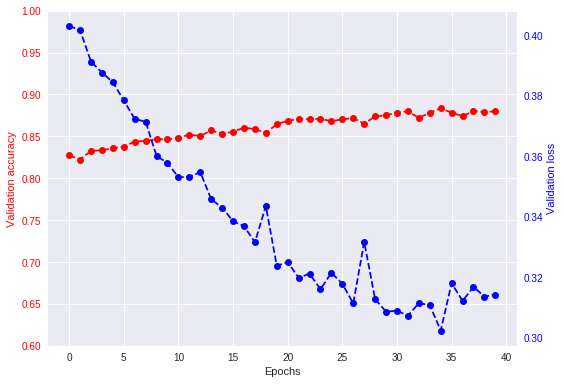

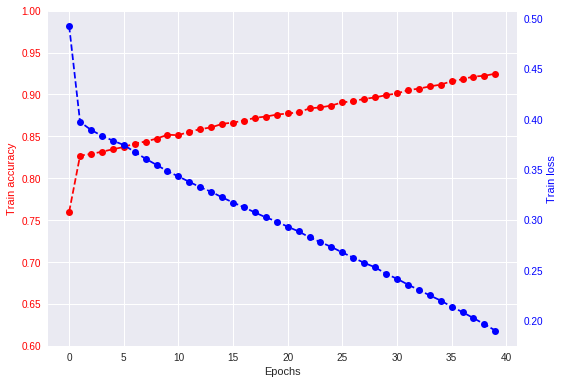

In [0]:
'''Plot figure acc & cost ~ epoch''' 

def plot_fancy_figure(x, y1, y2, scale_y1, scale_y2, label_x='x', label_y1='y1', label_y2='y2'):
  fig, ax1 = plt.subplots()
  ax1.set_xlabel(label_x)
  ax1.set_ylabel(label_y1, color='red')
  ax1.plot(x, y1, 'o--', color='red')
  plt.ylim(scale_y1)
  ax1.tick_params(axis='y', labelcolor='red')

  ax2 = ax1.twinx()
  color = 'tab:blue'
  ax2.set_ylabel(label_y2, color='blue')  # we already handled the x-label with ax1
  ax2.plot(x, y2, 'o--', color='blue')
  #plt.ylim(scale_y2)
  ax2.tick_params(axis='y', labelcolor='blue')

  plt.grid(linewidth='0')
  fig.tight_layout()
  plt.show()
  
  
  
#dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
plot_fancy_figure(np.arange(0, len(history.history['val_acc'])), history.history['val_acc'],
                  history.history['val_loss'], [0.6, 1], 0, 'Epochs', 'Validation accuracy', 'Validation loss')


plot_fancy_figure(np.arange(0, len(history.history['acc'])), history.history['acc'],
                  history.history['loss'], [0.6, 1], 0, 'Epochs', 'Train accuracy', 'Train loss')



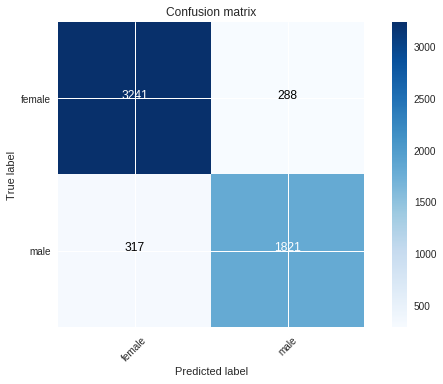

In [0]:
'''Visualise training logs'''

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(matrix, sex, title='Confusion matrix')

In [0]:
'''My test'''

my_test = ['Alex'] #names
label = [1]
sex = ["female", "male"]
a = []
for name in my_test:
  a.append(encode_in_number(name))
a = kr.preprocessing.sequence.pad_sequences(a,maxlen=max_len)


accr = model.evaluate(a,label)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

if accr[1] == 1:
  print(my_test[0], "truly recognised as", sex[label[0]], "name.")
else:
  print(my_test[0], "mistanekly recognised as", sex[label[0]], "name.")


1/1 [==============================] - 0s 14ms/step
Test set
  Loss: 0.337
  Accuracy: 1.000
Alex truly recognised as male name.
